---
#### Train
---

In [1]:
import pandas as pd
import os
import numpy as np
import time
import pickle
import warnings
from datetime import datetime
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization, Dropout, Conv1D, GlobalMaxPool1D, SimpleRNN
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

Using TensorFlow backend.


---
#### 일단 네이블 통해 받은 데이터로 훈련을 한다.
---

In [2]:
ct = pd.read_csv('training-data-Slice03-20200118.csv')

In [5]:
ct

,SLICE,DATETIME,UPLINK_THROUGHPUT,DNLINK_THROUGHPUT,ACTIVE_USER
0,Slice03,2020-01-09T09:00:00,12634988,168221782,1988
1,Slice03,2020-01-09T09:05:00,11855237,181769954,2121
2,Slice03,2020-01-09T09:10:00,13301155,200049739,2118
3,Slice03,2020-01-09T09:15:00,12944459,213688407,2207
4,Slice03,2020-01-09T09:20:00,12952297,163862849,2285
...,...,...,...,...,...
279,Slice03,2020-01-10T08:35:00,9513954,184697574,2036
280,Slice03,2020-01-10T08:40:00,10642316,166103144,2199
281,Slice03,2020-01-10T08:45:00,10101071,183592710,2147
282,Slice03,2020-01-10T08:50:00,12742560,192581044,2115


In [3]:
import numpy as np
def create_dataset(signal_data, look_back = 144):
    dataX, dataY = [], []
    for i in range(len(signal_data)-156):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[(i + look_back):(i+156), 0])
    return np.array(dataX), np.array(dataY)

look_back = 144 ## 하루. 

train = ct[['UPLINK_THROUGHPUT']].values.reshape(-1,1)
x_train, y_train = create_dataset(train, look_back)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

model = Sequential()
model.add(SimpleRNN(144, return_sequences= True))
model.add(BatchNormalization())
model.add(SimpleRNN(144))
model.add(Dense(12, activation = 'linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

# earlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min')
# mcp_save = ModelCheckpoint('/data01/CSB/CSB_Jupyter/PROBE/Pyfile/CSB-Modelling/10월16일/TANGO/best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

hist = model.fit(x_train/1e7, y_train/1e7, epochs=10, batch_size = 2)

Epoch 1/10
536/536 [==============================] - 49s 92ms/step - loss: 0.4487
Epoch 2/10
536/536 [==============================] - 41s 76ms/step - loss: 0.1670
Epoch 3/10
536/536 [==============================] - 38s 71ms/step - loss: 0.1556
Epoch 4/10
536/536 [==============================] - 38s 72ms/step - loss: 0.1474
Epoch 5/10
536/536 [==============================] - 38s 71ms/step - loss: 0.1824
Epoch 6/10
536/536 [==============================] - 39s 73ms/step - loss: 0.1745
Epoch 7/10
536/536 [==============================] - 39s 72ms/step - loss: 0.1552
Epoch 8/10
536/536 [==============================] - 39s 72ms/step - loss: 0.1446
Epoch 9/10
536/536 [==============================] - 40s 74ms/step - loss: 0.2713
Epoch 10/10
536/536 [==============================] - 37s 69ms/step - loss: 0.2039


#### model 저장

In [17]:
model.save('Slice03-prediction-uplink-throughput.h5')

#### 모델 제대로 돌아가는지 test 용

In [12]:
prediction = ct[['UPLINK_THROUGHPUT']][0:144 ].values
    
    
result = model.predict(np.reshape(prediction,(1,144,1))/1e7)*1e7

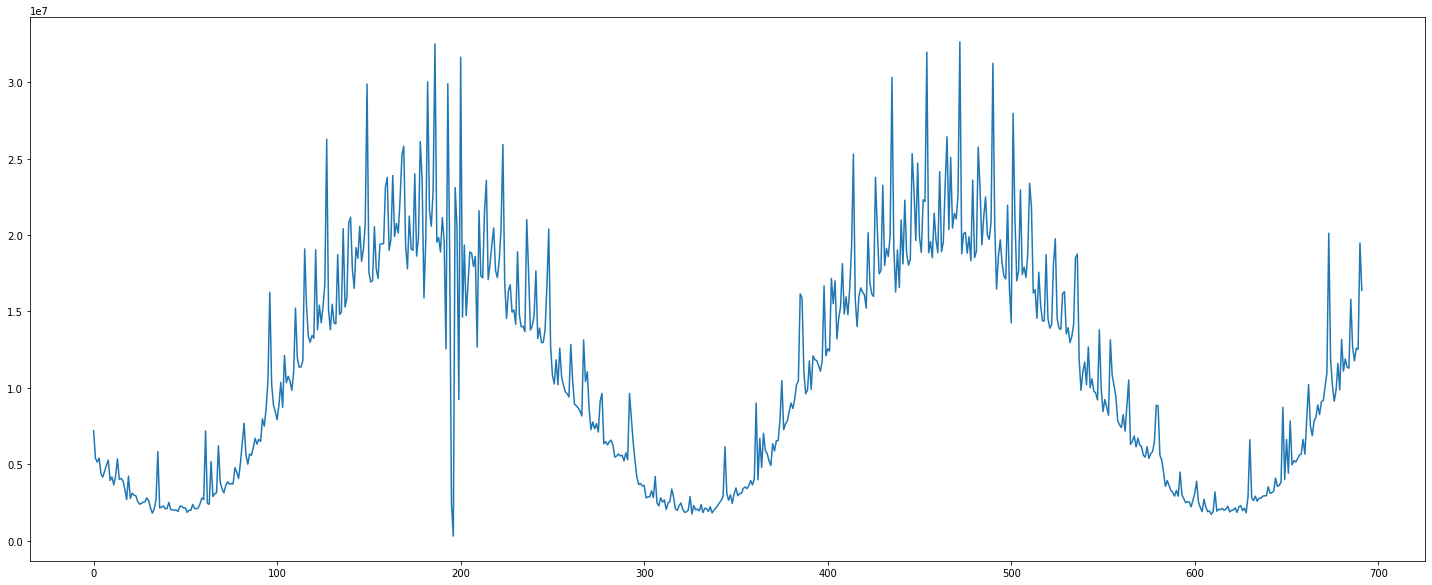

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))
plt.plot(ct[['UPLINK_THROUGHPUT']])
plt.show()

In [18]:
ct[['UPLINK_THROUGHPUT']]

,UPLINK_THROUGHPUT
0,12634988
1,11855237
2,13301155
3,12944459
4,12952297
...,...
279,9513954
280,10642316
281,10101071
282,12742560


In [14]:
test = pd.DataFrame(result[0])
test.columns =['UPLINK_THROUGHPUT']

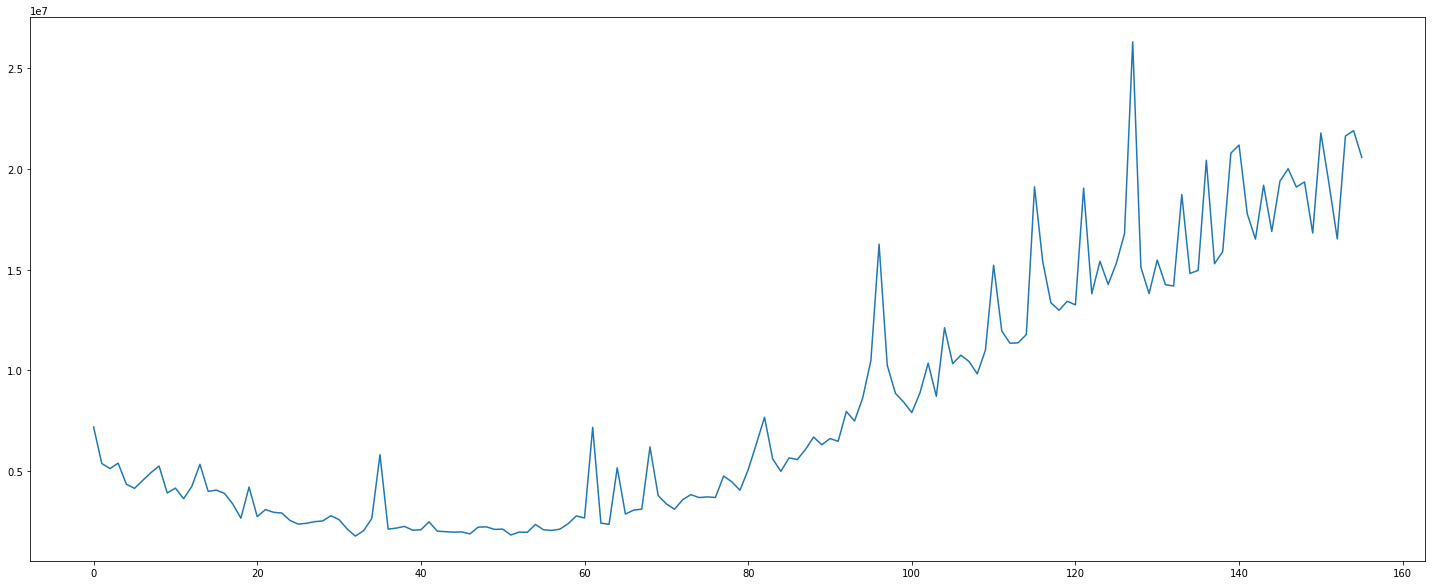

In [16]:
plt.figure(figsize=(25,10))
plt.plot(pd.concat([ct[['UPLINK_THROUGHPUT']][0:144],test]).reset_index(drop=True))

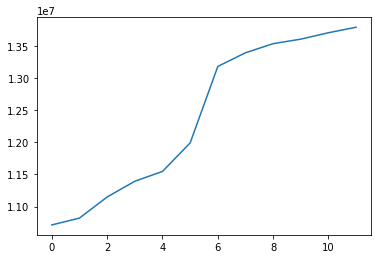

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(result[0])


In [17]:
result

array([[23239570., 23314178., 23373736., 24095618., 24127940., 24555864.,
        25043654., 25079338., 25499838., 26888886., 27011184., 27927210.]],
      dtype=float32)